In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
cur_path = "/content/drive/MyDrive/graph-fraud-detection/"
os.chdir(cur_path)
!pwd

/content/drive/MyDrive/graph-fraud-detection


In [3]:
!pip install dgl
#-cu101

In [4]:
import os
import sys
import glob

os.environ['DGLBACKEND'] = 'pytorch'

import torch as th
import dgl
import numpy as np

from gnn.estimator_fns import *
from gnn.graph_utils import *
from gnn.data import *
from gnn.utils import *
from gnn.pytorch_model import *
from gnn.train import *

Using backend: pytorch


DLG version: 0.6.1


In [5]:
file_list = glob.glob('./data/*edgelist.csv')

edges = ",".join(map(lambda x: x.split("/")[-1], [file for file in file_list if "relation" in file]))

Graph Neural Networks work by learning representation for nodes or edges of a graph that are well suited for some downstream task. We can model the fraud detection problem as a node classification task, and the goal of the graph neural network would be to learn how to use information from the topology of the sub-graph for each transaction node to transform the node's features to a representation space where the node can be easily classified as fraud or not.

Specifically, we will be using a relational graph convolutional neural network model (R-GCN) on a heterogeneous graph since we have nodes and edges of different types.

Hyperparameters
To train the graph neural network, we need to define a few hyperparameters that determine properties such as the class of graph neural network models we will be using, the network architecture and the optimizer and optimization parameters.

Here we're setting only a few of the hyperparameters, to see all the hyperparameters and their default values, see dgl-fraud-detection/estimator_fns.py. The parameters set below are:

- nodes is the name of the file that contains the node_ids of the target nodes and the node features.
- edges is a regular expression that when expanded lists all the filenames for the edgelists
- labels is the name of the file tha contains the target node_ids and their labels
- model specify which graph neural network to use, this should be set to r-gcn

The following hyperparameters can be tuned and adjusted to improve model performance

- batch-size is the number nodes that are used to compute a single forward pass of the GNN
- embedding-size is the size of the embedding dimension for non target nodes
- n-neighbors is the number of neighbours to sample for each target node during graph sampling for mini-batch training
- n-layers is the number of GNN layers in the model
- n-epochs is the number of training epochs for the model training job
- optimizer is the optimization algorithm used for gradient based parameter updates
- lr is the learning rate for parameter updates

In [6]:
params = {'nodes' : 'features.csv',
          'edges': 'relation*',
          'labels': 'tags.csv',
          'embedding-size': 64,
          'n-layers': 2,
          'n-epochs': 10,
          'optimizer': 'adam',
          'lr': 1e-2
        }

numpy version:1.19.5 PyTorch version:1.8.1+cu101 DGL version:0.6.1
Namespace(compute_metrics=True, dropout=0.2, edges='relation*', embedding_size=360, labels='tags.csv', lr=0.01, model_dir='./model/2021_04_21_08_11_39', n_epochs=500, n_hidden=16, n_layers=3, new_accounts='test.csv', nodes='features.csv', num_gpus=0, optimizer='adam', output_dir='./output', target_ntype='TransactionID', threshold=0, training_dir='./data', weight_decay=0.0005)
Getting relation graphs from the following edge lists : ['relation_card1_edgelist.csv', 'relation_card2_edgelist.csv', 'relation_card4_edgelist.csv', 'relation_card3_edgelist.csv', 'relation_card5_edgelist.csv', 'relation_ProductCD_edgelist.csv', 'relation_card6_edgelist.csv', 'relation_addr1_edgelist.csv', 'relation_addr2_edgelist.csv', 'relation_P_emaildomain_edgelist.csv', 'relation_R_emaildomain_edgelist.csv', 'relation_id_02_edgelist.csv', 'relation_id_01_edgelist.csv', 'relation_id_03_edgelist.csv', 'relation_TransactionID_edgelist.csv', 'rel

2021-04-21 15:16:27,872 INFO numexpr.utils: NumExpr defaulting to 4 threads.


Model and metadata saved


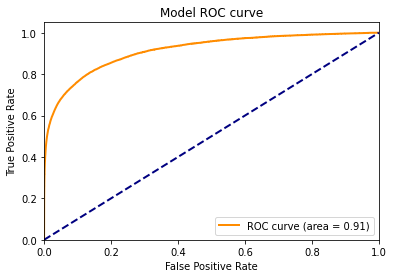

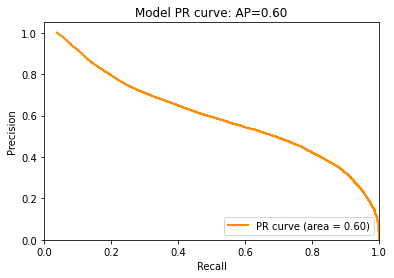

In [7]:
print('numpy version:{} PyTorch version:{} DGL version:{}'.format(np.__version__,
                                                                    th.__version__,
                                                                    dgl.__version__))

args = parse_args()
print(args)
args.edges = edges

args.edges = get_edgelists('relation*', args.training_dir)

g, features, target_id_to_node, id_to_node = construct_graph(args.training_dir,
                                                                args.edges,
                                                                args.nodes,
                                                                args.target_ntype)

mean, stdev, features = normalize(th.from_numpy(features))

print('feature mean shape:{}, std shape:{}'.format(mean.shape, stdev.shape))

g.nodes['target'].data['features'] = features

print("Getting labels")
n_nodes = g.number_of_nodes('target')

labels, _, test_mask = get_labels(target_id_to_node,
                                            n_nodes,
                                            args.target_ntype,
                                            os.path.join(args.training_dir, args.labels),
                                            os.path.join(args.training_dir, args.new_accounts))
print("Got labels")

labels = th.from_numpy(labels).float()
test_mask = th.from_numpy(test_mask).float()

n_nodes = th.sum(th.tensor([g.number_of_nodes(n_type) for n_type in g.ntypes]))
n_edges = th.sum(th.tensor([g.number_of_edges(e_type) for e_type in g.etypes]))

print("""----Data statistics------'
            #Nodes: {}
            #Edges: {}
            #Features Shape: {}
            #Labeled Test samples: {}""".format(n_nodes,
                                                    n_edges,
                                                    features.shape,
                                                    test_mask.sum()))

if args.num_gpus:
    cuda = True
    device = th.device('cuda:0')
else:
    cuda = False
    device = th.device('cpu')

print("Initializing Model")
in_feats = features.shape[1]
n_classes = 2

ntype_dict = {n_type: g.number_of_nodes(n_type) for n_type in g.ntypes}

model = get_model(ntype_dict, g.etypes, vars(args), in_feats, n_classes, device)
print("Initialized Model")

features = features.to(device)

labels = labels.long().to(device)
test_mask = test_mask.to(device)
# g = g.to(device)

loss = th.nn.CrossEntropyLoss()

# print(model)
optim = th.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

print("Starting Model training")
model, class_preds, pred_proba = train_fg(model, optim, loss, features, labels, g, g,
                                            test_mask, device, args.n_epochs,
                                            args.threshold,  args.compute_metrics)
print("Finished Model training")

print("Saving model")

if not os.path.exists(args.model_dir):
    os.makedirs(args.model_dir)

save_model(g, model, args.model_dir, id_to_node, mean, stdev)
print("Model and metadata saved")

In [1]:
%tb

No traceback available to show.
